In [91]:
import pygsti
from pygsti.circuits import Circuit
import random
from pygsti.modelpacks import smq1Q_XYZI as std
# Note that numpy 1.23 will break pygsti
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [2]:
model = std.target_model('CPTP')

In [3]:
model.from_vector( np.random.uniform(0, 0.1, model.num_params))

In [4]:
""" a model pack has labelled gates and standard state preps and measurements """
std.gates

[(), ('Gxpi2', 0), ('Gypi2', 0), ('Gzpi2', 0)]

In [5]:
"""access model memebers with their labels"""
print('rho0 in PP basis', model[('rho0')].to_dense())
print('Gxpi2 in PP basis\n', model[('Gxpi2', 0)].to_dense())
print('<<0| in PP basis', model[('Mdefault')]['0'].to_dense()) # note Povms are dictionaries of dictionaries

rho0 in PP basis [ 0.70710678  0.12827056 -0.08042541  0.66443548]
Gxpi2 in PP basis
 [[ 1.00000000e+00  0.00000000e+00  2.22044605e-16  1.57009246e-16]
 [-2.01556360e-02  9.14983912e-01  1.53922104e-01  1.38922924e-01]
 [ 7.31941573e-04  1.50326372e-01 -2.94601424e-02 -9.46528923e-01]
 [-2.01694082e-03 -1.42689681e-01  9.63121432e-01 -9.63682178e-02]]
<<0| in PP basis [ 0.70207326 -0.08413068  0.0106909   0.69462019]


In [6]:
def random_circuit(depth, model_pack=std):
    """
    works for any 1-qubit model pack and the XYZICnot 2-qubit pack
    """
    proc_spec = model_pack.processor_spec()
    layers = []
    for i in range(depth):
        gate = random.choice(proc_spec.gate_names)
        if gate == 'Gcnot':
            control = random.choice(proc_spec.qubit_labels)
            if control == 0:
                target = 1
            else:
                target = 0
            layers.append((gate, control, target))
        else:
            layers.append((gate, random.choice(proc_spec.qubit_labels)))
    return Circuit(layers, proc_spec.qubit_labels)

In [7]:
random_circuit(3)

Circuit(Gxpi2:0{idle}:0Gypi2:0@(0))

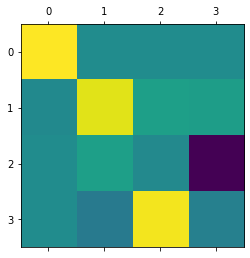

In [10]:
gx = model[('Gxpi2', 0)]
plt.matshow(gx.to_dense())

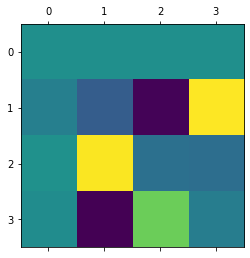

In [11]:
plt.matshow(gx.submembers()[1].errorgen.to_dense())

In [12]:
gx.to_vector()

array([0.03283682, 0.07904518, 0.07781037, 0.01335188, 0.06925751,
       0.04287618, 0.02953618, 0.07685783, 0.07630216, 0.02894503,
       0.09746674, 0.04913989])

In [13]:
print(gx.errorgen_coefficient_labels())
gx.errorgen_coefficients()

(('H', ('X',), (0,)), ('H', ('Y',), (0,)), ('H', ('Z',), (0,)), ('S', ('X',), (0,)), ('C', ('X', 'Y'), (0,)), ('A', ('X', 'Y'), (0,)), ('C', ('X', 'Z'), (0,)), ('A', ('X', 'Z'), (0,)), ('S', ('Y',), (0,)), ('C', ('Y', 'Z'), (0,)), ('A', ('Y', 'Z'), (0,)), ('S', ('Z',), (0,)))


OrderedDict([(('H', ('X',), (0,)), 0.03283682169487545),
             (('H', ('Y',), (0,)), 0.07904517792819776),
             (('H', ('Z',), (0,)), 0.07781037064277095),
             (('S', ('X',), (0,)), 0.00017827275564420846),
             (('C', ('X', 'Y'), (0,)), 0.0003943635633302954),
             (('A', ('X', 'Y'), (0,)), 0.0009247180505987251),
             (('C', ('X', 'Z'), (0,)), 0.0003864706831934139),
             (('A', ('X', 'Z'), (0,)), 0.0005724777379963231),
             (('S', ('Y',), (0,)), 0.011576113525834018),
             (('C', ('Y', 'Z'), (0,)), 0.011315504685806955),
             (('A', ('Y', 'Z'), (0,)), 0.005126156318839885),
             (('S', ('Z',), (0,)), 0.020412695379177732)])

In [14]:
def errorgen_from_circuit(circ, model):
    """
    Returns exp(x o L) from an error model and a circuit
    
    only produces the linear error generator
    """
    
    
    
    for idg, gate in enumerate(circ):
        
        

IndentationError: expected an indented block (<ipython-input-14-940ae0a9a1c2>, line 12)

In [167]:
class GateSet():
    """
    Holds the information for
        -all native gates, states, and measurements
        -all error generator features (in a feature dict)
        -map between gate labels and parameter index list (index set)
        -map between parameter indices and error features (feature dict) 
    """
    def __init__(self, model_pack, parameterization='CPTP'):
        # A list of error features, each one corresponding to one error generator in our H/S/C/A basis
        self.features = []
        # A list of error rates, each one corresponding to one feature in the above list
        self.rates = []
        # A dictionary which maps each gate/POVM/state-prep to its corresponding errors in `self.features`
        self.index_set = dict()
        model = self.target_model = model_pack.target_model(parameterization)
        self.gate_labels = model_pack.gates
        
        itr = 0
        # Errors for all gates in the model
        for gate in model_pack.gates:
            param_index_list = []
            for egentype in model[gate].submembers()[1].errorgen.lindblad_term_superops_and_1norms:
                for mat in egentype[0][:]:
                    # Add the error feature to the list
                    self.features.append(np.asarray(mat.todense()))
                    # create a new sympy variable to represent the rate associated to that feature
                    self.rates.append(sp.Symbol(f'x{itr}'))
                    param_index_list.append(itr)
                    itr += 1
            self.index_set[gate] = param_index_list
        # Errors for all measurements in the model
        for povm in model.povms.keys():
            param_index_list = []
            for egentype in model[povm].error_map.errorgen.lindblad_term_superops_and_1norms:
                for mat in egentype[0][:]:
                    self.features.append(np.asarray(mat.todense()))
                    param_index_list.append(itr)
                    itr += 1
            self.index_set[povm] = param_index_list
        # Errors for all state preparations in the model
        for prep in model.preps.keys():
            param_index_list = []
            for egentype in model[prep].error_map.errorgen.lindblad_term_superops_and_1norms:
                for mat in egentype[0][:]:
                    self.features.append(np.asarray(mat.todense()))
                    param_index_list.append(itr)
                    itr += 1
            self.index_set[prep] = param_index_list    
    
    def features_of(self, op_label):
        """Returns the list of error features associated with the given gate/POVM/state-prep"""
        indices = self.index_set[op_label]
        return [self.features[i] for i in indices]
    
    def rates_of(self, op_label):
        """Returns the list of error rates associated with the given gate/POVM/state-prep"""
        indices = self.index_set[op_label]
        return [self.rates[i] for i in indices]
    
    def error_generator_of(self, op_label):
        """Returns the error generator matrix associated with the given gate/POVM/state-prep"""
        indices = self.index_set[op_label]
        # Initialize using the first error generator
        result = self.features[indices[0]] * self.rates[indices[0]]
        # Add each error generator multiplied by its rate
        for i in indices[1:]:
            result += self.features[i] * self.rates[i]
        # Convert to a sympy matrix to keep track of variables
        return sp.Matrix(result)
    
    def target_op(self, op_label):
        """
        returns the target operation of the given operation
        """
        return self.target_model[op_label].to_dense()

    def native_meas(self):
        return [m.to_dense() for m in self.target_model['Mdefault'].values()]

    def rho0(self):
        return self.target_model['rho0'].to_dense()

In [169]:
def all_random_circuits(length):
    """
    returns all random circuits of given length
    """

In [170]:
gs = GateSet(std)

In [171]:
"""show the index set"""
gs.index_set

{(): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 ('Gxpi2', 0): [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 ('Gypi2', 0): [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 ('Gzpi2', 0): [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 Label('Mdefault'): [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 Label('rho0'): [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]}

In [172]:
"""show the features"""
gs.features

[array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, -2.+0.j],
        [ 0.+0.j,  0.+0.j,  2.+0.j,  0.+0.j]]),
 array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  2.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -2.+0.j,  0.+0.j,  0.+0.j]]),
 array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -2.+0.j,  0.+0.j],
        [ 0.+0.j,  2.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]]),
 array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -2.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, -2.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.-2.j, 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
  

In [177]:
gs.features_of((("Gxpi2"), 0))

[array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, -2.+0.j],
        [ 0.+0.j,  0.+0.j,  2.+0.j,  0.+0.j]]),
 array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  2.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -2.+0.j,  0.+0.j,  0.+0.j]]),
 array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -2.+0.j,  0.+0.j],
        [ 0.+0.j,  2.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]]),
 array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -2.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j,  0.+0.j, -2.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.-2.j, 0.+0.j, 0.+0.j, 0.+0.j]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
  

In [174]:
gs.target_op(("Gxpi2", 0))

array([[ 1.00000000e+00,  0.00000000e+00,  2.22044605e-16,
         1.57009246e-16],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.57009246e-16,  0.00000000e+00,  1.57009246e-16,
        -1.00000000e+00],
       [ 2.22044605e-16,  0.00000000e+00,  1.00000000e+00,
         1.57009246e-16]])

In [180]:
gs.rates_of(("Gxpi2", 0))

[x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23]

In [179]:
gs.error_generator_of(("Gxpi2", 0))

Matrix([
[                     0,                            0,                            0,                            0],
[-2.0*I*x20 + 2.0*I*x22,           -2.0*x19 - 2.0*x23, -2.0*x14 + 1.0*x16 + 1.0*x18,  2.0*x13 + 1.0*x17 + 1.0*x21],
[ 2.0*I*x17 - 2.0*I*x21,  2.0*x14 + 1.0*x16 + 1.0*x18,           -2.0*x15 - 2.0*x23, -2.0*x12 + 1.0*x20 + 1.0*x22],
[-2.0*I*x16 + 2.0*I*x18, -2.0*x13 + 1.0*x17 + 1.0*x21,  2.0*x12 + 1.0*x20 + 1.0*x22,           -2.0*x15 - 2.0*x19]])

In [306]:
class CircuitAnalyzer:
    """Performs operations on a given pygsti Circuit object,
    which is part of a given GateSet."""
    def __init__(self, circuit, gateset):
        self.gateset = gateset
        self.circuit = circuit
        # Extracts the gates in the circuit as a list of labels
        # This may only work for sngle-qubit gates as written?
        self.gates = list(circuit.layertup)
        # Finds their PTMs (pauli transfer matrices)
        self.gate_matrices = [gateset.target_op(gate) for gate in self.gates]
        # Extracts the error matrices corresponding to each of these gates
        self.errors = [gateset.error_generator_of(gate) for gate in self.gates]
        
    def left_errors(self):
        """Moves all gate errors to the left of the circuit,
        and returns the resulting list of conjugated error generators.
        
        NOTE: In our Circuit object, the gates are ordered
        left-to-right from first-applied to last-applied.
        However, the error terms in the result of this function, are ordered
        left-to-right as they would be in matrix multiplication."""
        
        left_errors = []
        # Process the errors from the end of the list to its beginning
        # Because that's the order they'll appear in the resulting matrix mult
        n = len(self.errors)
        for i in range(n-1, -1, -1):
            error = self.errors[i]
            # Conjugate by all gates being applied after i: gates i+1 through n
            for j in range(i+1, n):
                gate_matrix = self.gate_matrices[j].round(10)
                error = gate_matrix * error * np.linalg.inv(gate_matrix)
            left_errors.append(error)
        return left_errors
    
    def linear_F_map(self):
        """Returns the linear approximation of the F map,
        after moving all errors to the left. This approximation assumes they commute.
        The result is a function of the error terms of the gate set.
        """
        # Simply take the sum of all error generators after moving them to the left
        left_errors = self.left_errors()
        return sum(left_errors[1:], left_errors[0])
    
    def order2_F_map(self):
        """Returns the order-2 approximation of the F map,
        after moving all errors to the left, and applying order-2 BCH.
        The result is a function of the error terms of the gate set.
        """
        left_errors = self.left_errors()
        BCH2 = lambda X, Y : X + Y + (X@Y - Y@X) / 2
        # After extracting the left-side errors,
        # reduce the list to one matrix by applying BCH to each pair
        result = left_errors[0]
        for F in left_errors[1:]:
            result = BCH2(result, F)
        return result

In [307]:
# Create a simple two gate circuit
c = Circuit([("Gxpi2", 0), ("Gxpi2", 0)])
print(c)

Qubit 0 ---|Gxpi2|-|Gxpi2|---



In [308]:
# Initialize our analyzer object. Verify that the error maps for both X(pi/2) gates are identical
a = CircuitAnalyzer(c, gs)
a.errors[0]

Matrix([
[                     0,                            0,                            0,                            0],
[-2.0*I*x20 + 2.0*I*x22,           -2.0*x19 - 2.0*x23, -2.0*x14 + 1.0*x16 + 1.0*x18,  2.0*x13 + 1.0*x17 + 1.0*x21],
[ 2.0*I*x17 - 2.0*I*x21,  2.0*x14 + 1.0*x16 + 1.0*x18,           -2.0*x15 - 2.0*x23, -2.0*x12 + 1.0*x20 + 1.0*x22],
[-2.0*I*x16 + 2.0*I*x18, -2.0*x13 + 1.0*x17 + 1.0*x21,  2.0*x12 + 1.0*x20 + 1.0*x22,           -2.0*x15 - 2.0*x19]])

In [309]:
a.errors[1]

Matrix([
[                     0,                            0,                            0,                            0],
[-2.0*I*x20 + 2.0*I*x22,           -2.0*x19 - 2.0*x23, -2.0*x14 + 1.0*x16 + 1.0*x18,  2.0*x13 + 1.0*x17 + 1.0*x21],
[ 2.0*I*x17 - 2.0*I*x21,  2.0*x14 + 1.0*x16 + 1.0*x18,           -2.0*x15 - 2.0*x23, -2.0*x12 + 1.0*x20 + 1.0*x22],
[-2.0*I*x16 + 2.0*I*x18, -2.0*x13 + 1.0*x17 + 1.0*x21,  2.0*x12 + 1.0*x20 + 1.0*x22,           -2.0*x15 - 2.0*x19]])

In [310]:
# Move all errors to the left. Verify that the two outputs are correct
a.left_errors()[0]

Matrix([
[                     0,                            0,                            0,                            0],
[-2.0*I*x20 + 2.0*I*x22,           -2.0*x19 - 2.0*x23, -2.0*x14 + 1.0*x16 + 1.0*x18,  2.0*x13 + 1.0*x17 + 1.0*x21],
[ 2.0*I*x17 - 2.0*I*x21,  2.0*x14 + 1.0*x16 + 1.0*x18,           -2.0*x15 - 2.0*x23, -2.0*x12 + 1.0*x20 + 1.0*x22],
[-2.0*I*x16 + 2.0*I*x18, -2.0*x13 + 1.0*x17 + 1.0*x21,  2.0*x12 + 1.0*x20 + 1.0*x22,           -2.0*x15 - 2.0*x19]])

In [311]:
a.left_errors()[1]

Matrix([
[                     0,                           0,                            0,                            0],
[-2.0*I*x20 + 2.0*I*x22,          -2.0*x19 - 2.0*x23, -2.0*x13 - 1.0*x17 - 1.0*x21, -2.0*x14 + 1.0*x16 + 1.0*x18],
[ 2.0*I*x16 - 2.0*I*x18, 2.0*x13 - 1.0*x17 - 1.0*x21,           -2.0*x15 - 2.0*x19, -2.0*x12 - 1.0*x20 - 1.0*x22],
[ 2.0*I*x17 - 2.0*I*x21, 2.0*x14 + 1.0*x16 + 1.0*x18,  2.0*x12 - 1.0*x20 - 1.0*x22,           -2.0*x15 - 2.0*x23]])

In [312]:
# Extract the linear approximation of the F map: sum the above two errors
a.linear_F_map()

Matrix([
[                                             0,                                                          0,                                                          0,                                                         0],
[                        -4.0*I*x20 + 4.0*I*x22,                                         -4.0*x19 - 4.0*x23, -2.0*x13 - 2.0*x14 + 1.0*x16 - 1.0*x17 + 1.0*x18 - 1.0*x21, 2.0*x13 - 2.0*x14 + 1.0*x16 + 1.0*x17 + 1.0*x18 + 1.0*x21],
[ 2.0*I*x16 + 2.0*I*x17 - 2.0*I*x18 - 2.0*I*x21,  2.0*x13 + 2.0*x14 + 1.0*x16 - 1.0*x17 + 1.0*x18 - 1.0*x21,                               -4.0*x15 - 2.0*x19 - 2.0*x23,                                                  -4.0*x12],
[-2.0*I*x16 + 2.0*I*x17 + 2.0*I*x18 - 2.0*I*x21, -2.0*x13 + 2.0*x14 + 1.0*x16 + 1.0*x17 + 1.0*x18 + 1.0*x21,                                                    4.0*x12,                              -4.0*x15 - 2.0*x19 - 2.0*x23]])

In [319]:
# Extract the order-2 BCH approximation of the F_map
a.order2_F_map()

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                           0,                                                                                                                                                                                                                                                                                                                                                                                                                        0,                                                                                                                                                                                                       

In [320]:
# Simplify it
sp.expand(a.order2_F_map())

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                             0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              0,                                                                                                                                               

In [322]:
# We can take derivatives with respect to any given error parameter.
# Depedning on desired use case this can be incorporated as a function in our class
# i'd imagine, for finding Jacobians
sp.diff(a.order2_F_map(), 'x20')

Matrix([
[                                                                                                                         0,                                                          0,                                                          0,                                                         0],
[                                                                                                                    -4.0*I,                                                          0, -1.0*x13 + 1.0*x14 - 0.5*x16 - 0.5*x17 - 0.5*x18 - 0.5*x21, 1.0*x13 + 1.0*x14 - 0.5*x16 + 0.5*x17 - 0.5*x18 + 0.5*x21],
[-1.0*I*x16 + 1.0*I*x17 + 1.0*I*x18 - 1.0*I*x21 + 1.0*I*(2.0*x13 - 1.0*x17 - 1.0*x21) - 1.0*I*(2.0*x14 + 1.0*x16 + 1.0*x18), -1.0*x13 + 1.0*x14 + 0.5*x16 + 0.5*x17 + 0.5*x18 + 0.5*x21,                                                    4.0*x12,                                                         0],
[1.0*I*x16 + 1.0*I*x17 - 1.0*I*x18 - 1.0*I*x21 - 1.0*I*(-2.0*x13 + 1.0*x17 +